In [1]:
using PyPlot
using NBInclude
@nbinclude("ising_2d_lib.ipynb")

autocorrelation_time (generic function with 1 method)

# Visualization

In [2]:
function visualize()
    figure(figsize=(10,10))

    Length = 128

    Δtime = 100

    vec_Temperature = [1.5, 2.27, 3]
    for index_Temperature = 1:length(vec_Temperature)
        Config = initialize(Length, "random")
        time = 0

        Temperature = vec_Temperature[index_Temperature]
        
        subplot(3, 3, 0+index_Temperature)
        imshow(Config, cmap="gray")
        title("T = $Temperature, t = $time")
        xticks([])
        yticks([])

        subplot(3, 3, 3+index_Temperature)
        dynamics_tw(Config, Temperature, Δtime)
        time += Δtime
        imshow(Config, cmap="gray")
        title("T = $Temperature, t = $time")
        xticks([])
        yticks([])

        subplot(3, 3, 6+index_Temperature)
        dynamics_tw(Config, Temperature, Δtime)
        time += Δtime
        imshow(Config, cmap="gray")
        title("T = $Temperature, t = $time")
        xticks([])
        yticks([])    
    end    
end

visualize (generic function with 1 method)

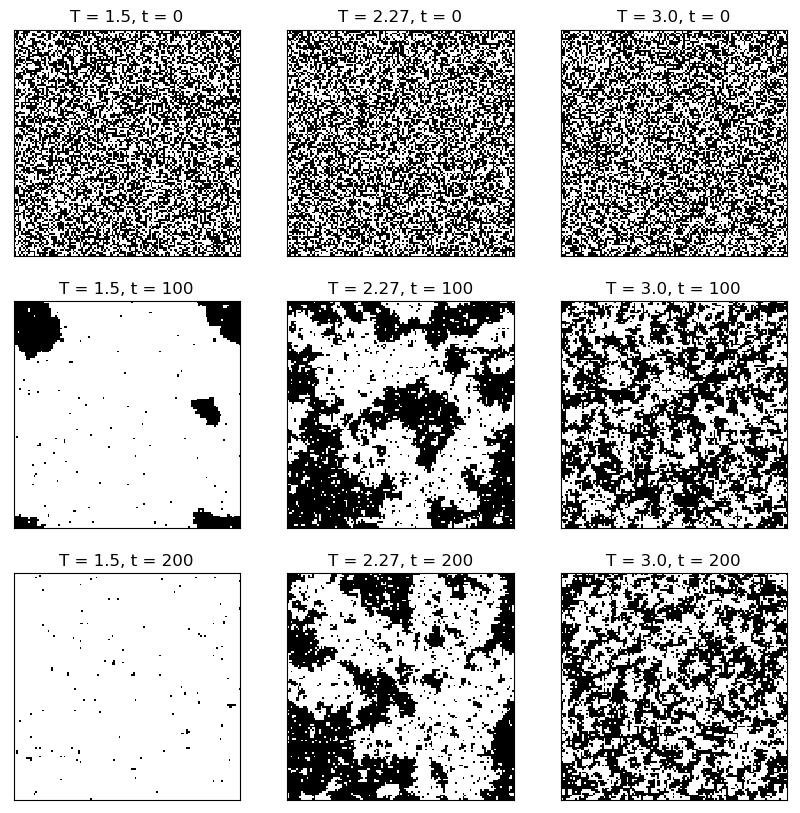

  1.235043 seconds (631.09 k allocations: 32.495 MiB, 1.25% gc time)


In [3]:
@time visualize()

# Thermalization

In [4]:
function plot_magnetization()
    Length = 16

    Temperature = 2.0
    num_sample = 100
    num_sample_burn = 0
    period_sample = 1

    for iteration = 1:10
        Config = initialize(Length, "random")
        vec_magnetization, vec_energy = stream_tw(Config, Temperature, num_sample, num_sample_burn, period_sample)
        plot(vec_magnetization./Length./Length)
    end
end

plot_magnetization (generic function with 1 method)

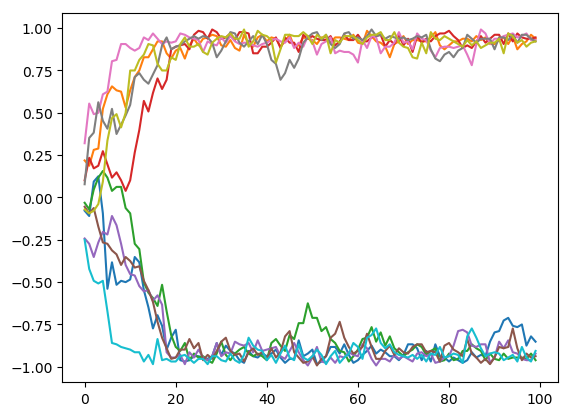

  0.281208 seconds (136.40 k allocations: 6.632 MiB)


In [5]:
@time plot_magnetization()

# Autocorrelation

## Autocorrelation function graph

In [6]:
function plot_autocorrelation_function()
    Length = 32
    Config = initialize(Length, "random")

    Temperature = 2.3
    num_sample = Int(1e5)
    num_sample_burn = 2000
    period_sample = 1

    for iteration = 1:5
        vec_magnetization, vec_energy = stream_tw(Config, Temperature, num_sample, num_sample_burn, period_sample)
        semilogy(autocorrelation_function(abs.(vec_magnetization), 1000))
    end

    ylim([exp(-5), 1])
    yticks([1, exp(-1), exp(-2), exp(-3), exp(-4), exp(-5)],["1", L"$1/e$", L"$1/e^2$", L"$1/e^3$", L"$1/e^4$", L"$1/e^5$"])
    grid()
end

plot_autocorrelation_function (generic function with 1 method)

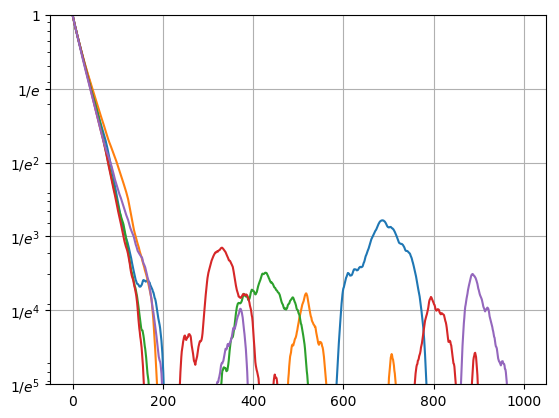

  8.630343 seconds (158.68 k allocations: 19.456 MiB, 0.08% gc time)


In [7]:
@time plot_autocorrelation_function()

Autocorrelation function of various methods

In [8]:
function compare_autocorrelation_function()
    Length = 32
    Config = initialize(Length, "random")

    Temperature = 2.27
    num_sample = Int(1e6)
    num_sample_burn = 2000
    period_sample = 1

    vec_magnetization, vec_energy = @time stream_tw(Config, Temperature, num_sample, num_sample_burn, period_sample)
    semilogy(autocorrelation_function(abs.(vec_magnetization), 1000))

    vec_magnetization, vec_energy = @time stream_rs(Config, Temperature, num_sample, num_sample_burn, period_sample)
    semilogy(autocorrelation_function(abs.(vec_magnetization), 1000))

    vec_magnetization, vec_energy = @time stream_glauber_tw(Config, Temperature, num_sample, num_sample_burn, period_sample)
    semilogy(autocorrelation_function(abs.(vec_magnetization), 1000))

    vec_magnetization, vec_energy = @time stream_glauber_rs(Config, Temperature, num_sample, num_sample_burn, period_sample)
    semilogy(autocorrelation_function(abs.(vec_magnetization), 1000))

    yticks([1, exp(-1), exp(-2), exp(-3)],["1", L"$1/e$", L"$1/e^2$", L"$1/e^3$"])
    ylim([exp(-3), 1])
    grid()

    xlabel("Time")
    ylabel("Autocorrelation")
    legend(["Metropolis, Typewriter", "Metropolis, Ranom-site", "Glauber, Typewriter", "Glauber, Random-site"])
end

compare_autocorrelation_function (generic function with 1 method)

 14.208790 seconds (11 allocations: 15.259 MiB, 0.04% gc time)
 79.217379 seconds (9 allocations: 15.259 MiB, 0.00% gc time)
 52.913335 seconds (5 allocations: 15.259 MiB, 0.04% gc time)


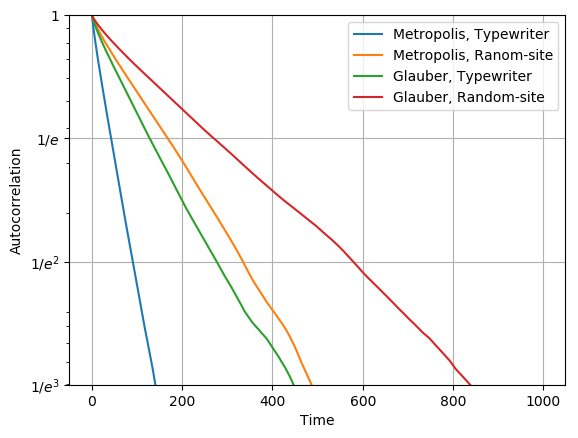

113.072902 seconds (5 allocations: 15.259 MiB)


PyObject <matplotlib.legend.Legend object at 0x0000000031AE9EF0>

In [9]:
compare_autocorrelation_function()

## Correlation time

Codes below saves correlation time data in "./data/correlation_time_...". See **data_analysis.ipynb** for plots and analysis.

In [10]:
function calc_correlation_time_tw(Length::Int64)
    Config = initialize(Length, "ordered")

    num_sample = Int(1e6)
    num_sample_burn = 1000
    period_sample = 1

    vec_Temperature = vcat(1.5:0.1:2.2, 2.21:0.01:2.39, 2.4:0.1:3)
    data_tau_m = zeros(length(vec_Temperature))
    data_tau_e = zeros(length(vec_Temperature))

    file = open(@sprintf("data/correlation_time_tw_L%d.txt",Length), "w")
    for index_Temperature = 1:length(vec_Temperature)
        Temperature = vec_Temperature[index_Temperature]
        vec_magnetization, vec_energy = stream_tw(Config, Temperature, num_sample, num_sample_burn, period_sample)

        data_tau_m[index_Temperature] = autocorrelation_time(abs.(vec_magnetization), 1000)
        data_tau_e[index_Temperature] = autocorrelation_time(vec_energy, 1000)    
        write(file, "$Temperature\t$(data_tau_m[index_Temperature])\t$(data_tau_e[index_Temperature])\n")
        flush(file)
    end
    close(file)
end

calc_correlation_time_tw (generic function with 1 method)

In [11]:
function calc_correlation_time_rs(Length::Int64)
    Config = initialize(Length, "ordered")

    num_sample = Int(1e6)
    num_sample_burn = 1000
    period_sample = 1

    vec_Temperature = vcat(1.5:0.1:2.2, 2.21:0.01:2.39, 2.4:0.1:3)
    data_tau_m = zeros(length(vec_Temperature))
    data_tau_e = zeros(length(vec_Temperature))

    file = open(@sprintf("data/correlation_time_rs_L%d.txt",Length), "w")
    for index_Temperature = 1:length(vec_Temperature)
        Temperature = vec_Temperature[index_Temperature]
        vec_magnetization, vec_energy = stream_rs(Config, Temperature, num_sample, num_sample_burn, period_sample)

        data_tau_m[index_Temperature] = autocorrelation_time(abs.(vec_magnetization), 1000)
        data_tau_e[index_Temperature] = autocorrelation_time(vec_energy, 1000)    
        write(file, "$Temperature\t$(data_tau_m[index_Temperature])\t$(data_tau_e[index_Temperature])\n")
        flush(file)
    end
    close(file)
end

calc_correlation_time_rs (generic function with 1 method)

In [12]:
@time calc_correlation_time_tw(16)
@time calc_correlation_time_tw(24)
@time calc_correlation_time_tw(32)
@time calc_correlation_time_tw(48)
@time calc_correlation_time_tw(64)

261.771095 seconds (511.05 k allocations: 801.646 MiB, 0.04% gc time)
411.436299 seconds (273.68 k allocations: 789.743 MiB, 0.03% gc time)
620.520101 seconds (273.68 k allocations: 789.738 MiB, 0.02% gc time)
1215.734030 seconds (273.68 k allocations: 789.729 MiB, 0.01% gc time)
2069.506536 seconds (273.68 k allocations: 789.720 MiB, 0.01% gc time)


In [13]:
@time calc_correlation_time_rs(16)
@time calc_correlation_time_rs(24)
@time calc_correlation_time_rs(32)
@time calc_correlation_time_rs(48)
@time calc_correlation_time_rs(64)

813.708734 seconds (285.72 k allocations: 790.296 MiB, 0.01% gc time)
1647.969121 seconds (273.68 k allocations: 789.716 MiB, 0.01% gc time)
2834.265184 seconds (273.68 k allocations: 789.696 MiB, 0.00% gc time)
6176.655562 seconds (273.68 k allocations: 789.652 MiB, 0.00% gc time)
10868.521599 seconds (273.68 k allocations: 789.610 MiB, 0.00% gc time)


# Physical quantities

Codes below saves mean absolute magnetization, variance of magnetization, mean energy, and variance of energy data in "./data/magnetization_...". See **data_analysis.ipynb** for plots and analysis.

In [14]:
function calc_magnetization(Length::Int64)
    Config = initialize(Length, "ordered")

    num_sample = 10000
    num_sample_burn = 1000

    vec_Temperature = vcat(1.5:0.1:2.2, 2.21:0.01:2.39, 2.4:0.1:3)
    data_magnetization = zeros(length(vec_Temperature))
    data_chi = zeros(length(vec_Temperature))
    data_energy = zeros(length(vec_Temperature))
    data_cv = zeros(length(vec_Temperature))

    file = open(@sprintf("data/magnetization_L%d.txt",Length), "w")
    for index_Temperature = 1:length(vec_Temperature)
        Temperature = vec_Temperature[index_Temperature]
        if 2.1 < Temperature < 2.5
            period_sample = floor(Int, 30 * Length^2 /16/16)
        else
            period_sample = 30
        end

        magnetization, chi, energy, cv = quantity_tw(Config, Temperature, num_sample, num_sample_burn, period_sample)

        data_magnetization[index_Temperature] = magnetization /Length^2
        data_chi[index_Temperature] =  chi /Length^4
        data_energy[index_Temperature] = energy /Length^2
        data_cv[index_Temperature] =  cv /Length^4

        write(file, "$Temperature\t$(data_magnetization[index_Temperature])\t$(data_chi[index_Temperature])\t$(data_energy[index_Temperature])\t$(data_cv[index_Temperature])\n")
        flush(file)   
    end
    close(file)
end

calc_magnetization (generic function with 1 method)

In [15]:
@time calc_magnetization(16)
@time calc_magnetization(24)
@time calc_magnetization(32)
@time calc_magnetization(48)
@time calc_magnetization(64)

 36.030790 seconds (74.24 k allocations: 3.384 MiB, 0.03% gc time)
140.182179 seconds (737 allocations: 42.859 KiB)
402.448943 seconds (740 allocations: 43.625 KiB)
1875.772648 seconds (743 allocations: 44.922 KiB)
5755.119397 seconds (746 allocations: 46.953 KiB)
